In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import copy

import seaborn as sns
from matplotlib import pyplot as plt

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, Normalizer

GPU: False
Mounted at /content/drive


In [89]:
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/datasets/fashion-mnist_train.csv")

label_dict = {0:'top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle'}

class_num = 10

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

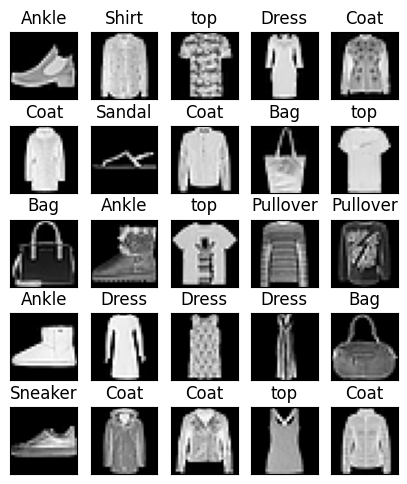

In [91]:
r = 5
c = 5
fig=plt.figure(figsize=(r, c*1.2), dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(label_dict[Y[i]])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [92]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [93]:
#converting our data into a datloader object.

trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y = torch.from_numpy(trn_y).type(torch.LongTensor)

val_x = torch.from_numpy(val_x).type(torch.FloatTensor)
val_y = torch.from_numpy(val_y).type(torch.LongTensor)

In [94]:
from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
val = TensorDataset(val_x,val_y)

trn = DataLoader(trn,batch_size=1000)
val = DataLoader(val,batch_size=1000)

In [95]:
shape = trn_x[0].shape
shape

torch.Size([784])

In [96]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,100)
        self.linear3 = nn.Linear(100,64)
        self.linear4 = nn.Linear(64,10)
    
    def forward(self,X):
        X1 = F.relu(self.linear1(X))
        X2 = F.relu(self.linear2(X1))
        X3 = F.relu(self.linear3(X2))
        X4 = self.linear4(X3)
        return X1, X2, X3, F.log_softmax(X4, dim=1)

mlp = Model()

if cuda:
    mlp.cuda()
    
print(mlp)    

Model(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)


In [97]:
#define our optimizer
from torch.optim import Adam

optimizer = Adam(mlp.parameters(), lr=1e-3)

In [98]:
def compute_val_loss(val_x,val_y,model):
    if cuda:
        val_x,val_y = val_x.cuda(),val_y.cuda()
    output = model(val_x)[3]
    loss = F.cross_entropy(output,val_y)
    return loss

In [99]:
%%time
EPOCHS = 10

trn_loss = []
val_loss = []

mlp.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):

        if cuda:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()
        
        _, _, _, y_pred = mlp(data)

        loss = F.cross_entropy(y_pred, target)
        trn_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_val_loss(val_x,val_y,mlp)
        val_loss.append(loss.cpu().data.item())

    print("Epoch: {} | loss: {} | val_loss: {}".format(epoch+1,trn_loss[-1],val_loss[-1]))

Epoch: 1 | loss: 0.683887243270874 | val_loss: 0.7050036787986755
Epoch: 2 | loss: 0.5197817087173462 | val_loss: 0.5298317670822144
Epoch: 3 | loss: 0.4646727740764618 | val_loss: 0.48329171538352966
Epoch: 4 | loss: 0.4352404773235321 | val_loss: 0.45598262548446655
Epoch: 5 | loss: 0.41016244888305664 | val_loss: 0.4339776635169983
Epoch: 6 | loss: 0.39352279901504517 | val_loss: 0.41870683431625366
Epoch: 7 | loss: 0.38013148307800293 | val_loss: 0.40680554509162903
Epoch: 8 | loss: 0.3704954981803894 | val_loss: 0.39386385679244995
Epoch: 9 | loss: 0.36042818427085876 | val_loss: 0.3801342844963074
Epoch: 10 | loss: 0.35584691166877747 | val_loss: 0.3698708117008209
CPU times: user 2min 57s, sys: 189 ms, total: 2min 57s
Wall time: 2min 58s


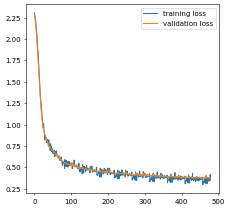

In [100]:
plt.figure(figsize=(5,5),dpi=50)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [101]:
def predict(model,val_x,ret_fm=False):
    """
    ret_fm: when set True, return feature map of layers
    """
    if cuda: val_x = val_x.cuda()
    out = model(val_x)
   
    ret = []
    y_preds = []
    if(ret_fm == False):
        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
        
        ret = y_preds
    else:
        f1 = out[0].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 256
        f2 = out[1].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 100
        f3 = out[2].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 64

        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
            
        ret = (f1, f2, f3, y_preds)
    
    return ret

In [102]:
pred = predict(mlp,val_x)

Accuracy: 86.8 %


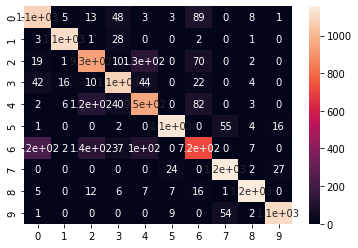

In [103]:
cm = confusion_matrix(val_y.numpy(), pred)

plt.figure()
sns.heatmap(cm,annot=True)

print("Accuracy:",accuracy_score(val_y.numpy(),pred)*100,"%")

tensor(0)


Text(0.5, 1.0, 'fm of layer2')

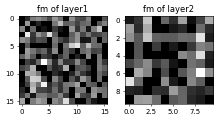

In [104]:
sp1 = val_x[0, :].reshape(1,-1)   # take one sample from validation set [1, 784]

res1 = predict(mlp,sp1,ret_fm=True)   # then make a prediction

print(val_y[0])  # true lable of the sample

plt.figure(figsize=(5, 3), dpi=50)
plt.subplot(121)
plt.imshow(res1[0].reshape(16, 16), cmap='gray')
plt.title("fm of layer1")
plt.subplot(122)
plt.imshow(res1[1].reshape(10, 10), cmap='gray')
plt.title("fm of layer2")

In [105]:
# begin testing
pred = predict(mlp, val_x, ret_fm=True)    # return (f1, f2, f3, y_preds)
pred[0].shape, pred[1].shape, pred[2].shape

((12000, 256), (12000, 100), (12000, 64))

Each layer generates either of the two feature maps: 

1. **positive** feature map(on the correctly classified sample)
2. **negative** feature map(on the mis-classified sample)

i.e. for any class $c$ we have:
$$\bar x_{pos,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{pos,c}^{(m)}$$
and
$$\bar x_{neg,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{neg,c}^{(m)}$$

In [106]:
layer_num = len(pred) - 1

In [107]:
target = val_y.numpy()
y_pred = pred[-1]

benchmarks = dict()
for l in range(layer_num):      # for all layers
    benchmarks[l] = {'pos':None, 'neg':None}     # feature map dict {layer0: {pos_dict, neg_dict}, layer1:{},,,}
    
    current_layer_fm = pred[l]                    # size: 12000*256
    pos_dict = dict()               # {'0': (numpy(1*256), t)}  t is the times '0' is visited
    neg_dict = dict()
    for i in range(current_layer_fm.shape[0]):    # for all samples
        if(y_pred[i] == target[i]):
            if target[i] not in pos_dict:   # if the first time
                pos_dict[target[i]] = (current_layer_fm[i], 1)
            else:
                t = pos_dict[target[i]][1]
                pos_dict[target[i]] = (pos_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                pos_dict[target[i]][1] += 1
        else:
            if target[i] not in neg_dict:
                neg_dict[target[i]] = (current_layer_fm[i], 1)
            else:
                t = neg_dict[target[i]][1]
                neg_dict[target[i]] = (neg_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                neg_dict[target[i]][1] += 1
    
    benchmarks[l]['pos'] = pos_dict
    benchmarks[l]['neg'] = neg_dict

In [108]:
def distance(benchmark, feature_map, method='L2', norm=True):
    """
    calculate the similarity between benchmark and a feature map
    """

    benchmark = benchmark.reshape(-1, 1)
    feature_map = feature_map.reshape(-1, 1)

    if norm is True:
        scaler = StandardScaler()
        benchmark = scaler.fit_transform(benchmark)
        feature_map = scaler.fit_transform(feature_map)

    if method == 'L2':
        return np.linalg.norm(benchmark - feature_map)
    
    raise Exception("No designated method found.")

class 0, layer 0, sim: 0.101815
class 0, layer 1, sim: 0.182946
class 0, layer 2, sim: 0.229194
class 1, layer 0, sim: 0.099460
class 1, layer 1, sim: 0.183299
class 1, layer 2, sim: 0.184949
class 2, layer 0, sim: 0.141468
class 2, layer 1, sim: 0.229051
class 2, layer 2, sim: 0.359548
class 3, layer 0, sim: 0.076633
class 3, layer 1, sim: 0.152520
class 3, layer 2, sim: 0.192312
class 4, layer 0, sim: 0.090033
class 4, layer 1, sim: 0.201854
class 4, layer 2, sim: 0.329646
class 5, layer 0, sim: 0.067637
class 5, layer 1, sim: 0.147250
class 5, layer 2, sim: 0.208438
class 6, layer 0, sim: 0.100896
class 6, layer 1, sim: 0.174364


<ipython-input-109-2a5105cca28f>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3, 1), dpi=50)


class 6, layer 2, sim: 0.261542
class 7, layer 0, sim: 0.155974
class 7, layer 1, sim: 0.322714
class 7, layer 2, sim: 0.396181
class 8, layer 0, sim: 0.065499
class 8, layer 1, sim: 0.127170
class 8, layer 2, sim: 0.163216
class 9, layer 0, sim: 0.070770
class 9, layer 1, sim: 0.168445
class 9, layer 2, sim: 0.245397


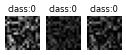

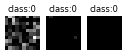

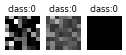

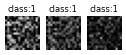

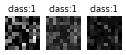

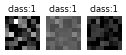

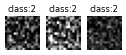

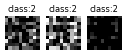

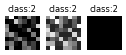

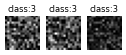

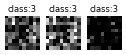

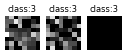

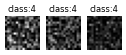

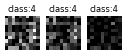

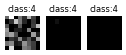

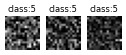

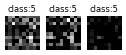

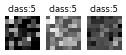

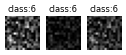

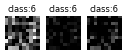

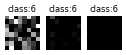

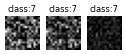

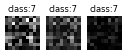

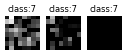

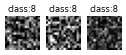

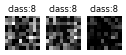

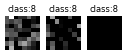

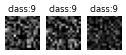

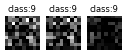

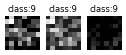

In [109]:
for c in range(class_num):
    for l in range(layer_num):
        fig = plt.figure(figsize=(3, 1), dpi=50)

        pos_bm = benchmarks[l]['pos'][c]
        neg_bm = benchmarks[l]['neg'][c]

        pos_bm = pos_bm.reshape(int(np.sqrt(len(pos_bm))), -1)
        neg_bm = neg_bm.reshape(int(np.sqrt(len(neg_bm))), -1)
        diff_bm = np.abs(np.subtract(pos_bm, neg_bm))

        imgs = [pos_bm, neg_bm, diff_bm]

        sim = 1 / distance(pos_bm, neg_bm, 'L2')

        for i, img in enumerate(imgs):
            plt.subplot(1,3,i+1)
            plt.axis('off')
            plt.title('class:' + str(c))
            plt.imshow(img, cmap='gray')
            plt.clim(np.min(pos_bm), np.max(pos_bm))
        
        print('class %d, layer %d, sim: %f' % (c, l, sim))

In [110]:
y_pred_flat = np.array(y_pred).reshape(1, -1)[0]
y_pred_flat

array([4, 2, 2, ..., 0, 1, 7])

In [111]:
val_y

tensor([0, 2, 2,  ..., 0, 1, 7])

- TODO: count similarities on all sample data, find a threshold

In [125]:
%%time
# init dict
dsb = dict()    # distribution dict
for l in range(layer_num):
    pos_dict = dict()
    neg_dict = dict()
    for c in np.unique(val_y):
        pos_dict[c] = []
        neg_dict[c] = []
    dsb[l] = {'pos': pos_dict, 'neg': neg_dict}

for i in range(val_x.shape[0]):
    pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)
    y_pred = pred[-1][0]
    target = int(val_y[i].numpy())

    for l in range(layer_num):  # compare on each layer
        bench_fm = benchmarks[l]['pos'][target]    # there're two benchmarks, only take positive one since it's meaningful
        fm = pred[l]

        sim = 1 / distance(bench_fm, fm, method='L2')

        if y_pred == target:
            dsb[l]['pos'][target].append(sim)
        else:
            dsb[l]['neg'][target].append(sim)

CPU times: user 32.6 s, sys: 123 ms, total: 32.7 s
Wall time: 34.1 s


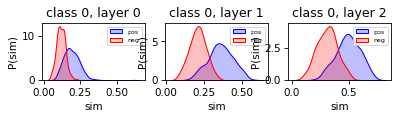

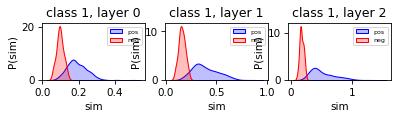

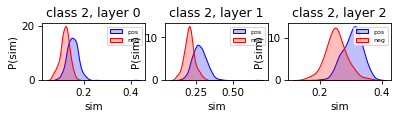

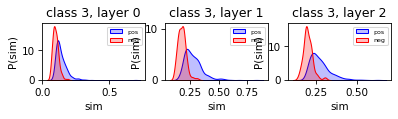

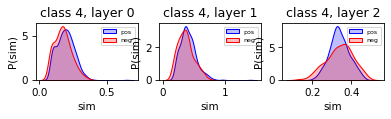

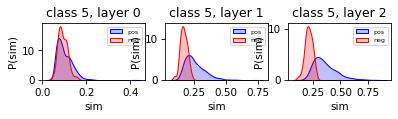

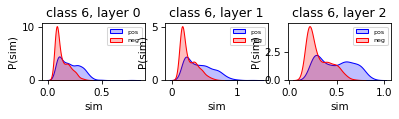

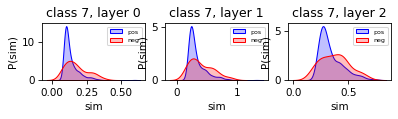

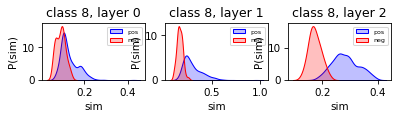

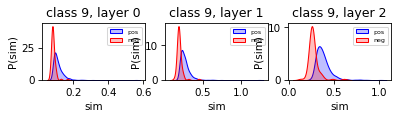

In [126]:
for c in range(class_num):
    fig = plt.figure(figsize=(6, 1), dpi=75)
    for l in range(layer_num):
        
        pos_data = dsb[l]['pos'][c]
        neg_data = dsb[l]['neg'][c]
        
        plt.subplot(1, layer_num, l+1)
        ax = sns.kdeplot(pos_data, color="Blue", fill = True)
        ax = sns.kdeplot(neg_data, ax=ax, color="Red", fill= True)
        ax.legend(["pos","neg"],loc='upper right',prop={'size': 6})
        ax.set_ylabel('P(sim)')
        ax.set_xlabel('sim')
        ax.set_title('class %d, layer %d' % (c, l))

&emsp;&emsp;~~~Notice that the distribution of postive samples and negative samples are almost indentical on class 2, same can be observed on class 6. Refer to the classification accuracy, we find the network yield poor performance on these two class when the kernel density estimation curves look similar. This Indicates the network can not distinguish the classes effectively, leading to an identical distribution on both postive and negative samples.~~~(OUTDATED)

27 March update:

Introduced normalization into distance function, now we can see for most classes there is a lower similarity on negative features.

In [114]:
correct_list = [0] * 10
counter_list = [0] * 10
for i in range(len(val_y)):
    counter_list[val_y[i]] += 1
    if(val_y[i] == y_pred_flat[i]):
        correct_list[val_y[i]] += 1

for i in range(len(correct_list)):
    print('class %d acc: %f' % (i, correct_list[i] / counter_list[i]))

class 0 acc: 0.863891
class 1 acc: 0.969459
class 2 acc: 0.798456
class 3 acc: 0.886792
class 4 acc: 0.792154
class 5 acc: 0.935802
class 6 acc: 0.586263
class 7 acc: 0.956126
class 8 acc: 0.955261
class 9 acc: 0.943541


Note: Take out those neg samples with large sim -> how are they classified to pos sample?

Note: take 1 neg with very large sim and 1 pos

4 kinds of images: pos+sim, pos-sim, neg+sim, neg-sim

find 5 pics for each

In [115]:
obs_l = 0   # layer in observance
obs_c = 6   # class in observance

Q1_pos = np.quantile(dsb[obs_l]['pos'][obs_c], 0.25)
Q3_pos = np.quantile(dsb[obs_l]['pos'][obs_c], 0.75)
Q1_neg = np.quantile(dsb[obs_l]['neg'][obs_c], 0.25)
Q3_neg = np.quantile(dsb[obs_l]['neg'][obs_c], 0.75)

imobs_dict = {'pos_Q1': [], 'pos_Q3': [], 'neg_Q1': [], 'neg_Q3': []}
for i in range(val_x.shape[0]):
    if(int(val_y[i]) == obs_c):     # only class in observance will be picked up       
        pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)

        y_pred = pred[-1][0]
        target = obs_c

        fm = pred[obs_l]
        benchmark = benchmarks[obs_l]['pos'][obs_c]
        sim = 1 / distance(benchmark, fm)

        if(y_pred == target):   # pos
            if(sim < Q1_pos and len(imobs_dict['pos_Q1']) < 5):
                imobs_dict['pos_Q1'].append(i)  # put index
            elif(sim > Q3_pos and len(imobs_dict['pos_Q3']) < 5):
                imobs_dict['pos_Q3'].append(i)
        else:
            if(sim < Q1_neg and len(imobs_dict['neg_Q1']) < 5):
                imobs_dict['neg_Q1'].append(i)  # put index
            elif(sim > Q3_neg and len(imobs_dict['neg_Q3']) < 5):
                imobs_dict['neg_Q3'].append(i)
        
        # found 5 imgs for 4 types, exit
        if(len(imobs_dict['pos_Q1']) == 5 and len(imobs_dict['pos_Q3']) == 5 and 
           len(imobs_dict['neg_Q1']) == 5 and len(imobs_dict['neg_Q3']) == 5):
           break

if(len(imobs_dict['pos_Q1']) != 5 or len(imobs_dict['pos_Q3']) != 5 or 
   len(imobs_dict['neg_Q1']) != 5 or len(imobs_dict['neg_Q3']) != 5):
   raise  Exception("Fetch images failed.")

The first row are the images that are classified correctly but have a low similarity with the benchmark of the class.

The second row are the images classified correctly whose similarity is higher than 75% of total samples.

The third row images are misclassified and has a low similarity to benchmark.

The forth row images are misclassified but has a high similarity to benchmark.

The 2nd row looks really eriee... how are these clothes shirts??? They could look like anything(e.g. shirt, coat...) but shirts. NO wonders the network can not gain a high acc..

class 6: Shirt, layer 0


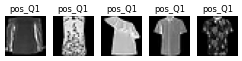

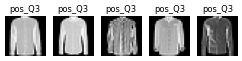

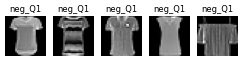

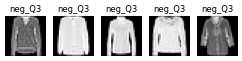

In [116]:
print('class %d: %s, layer %d' % (obs_c, label_dict[obs_c], obs_l))
for key in list(imobs_dict.keys()):
    fig = plt.figure(dpi=50)
    for i, index in enumerate(imobs_dict[key]):
        img = val_x[index].reshape(int(np.sqrt(len(val_x[index]))), -1)
        plt.subplot(1,5,i+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
        plt.title(key)

In [117]:
def trace(x, target, benchmarks):
    """
    x: a sample, input image
    target: true label of this sample
    """
    pred = predict(mlp, x, True)
    print("pred label: " + str(pred[-1][0]))

    traces = []
    for l in range(len(pred) - 1):
        fm = pred[l]                    # feature map on current layer
        bms = [benchmarks[l]['pos'][i] for i in range(len(benchmarks[l]['pos']))]
        sims = [round(1 / distance(bm, fm, 'L2'), 6) for bm in bms]
        traces.append(np.argmax(sims))
        print(sims)
    
    return traces

In [118]:
imobs_dict['pos_Q1'], imobs_dict['pos_Q3'], imobs_dict['neg_Q1'], imobs_dict['neg_Q3']

([33, 122, 325, 355, 378],
 [164, 198, 211, 282, 323],
 [6, 48, 214, 608, 626],
 [72, 101, 169, 181, 208])

In [119]:
trace(val_x[4, :].reshape(1,-1), 6, benchmarks)

pred label: 7
[0.043934, 0.047455, 0.045513, 0.054402, 0.052111, 0.068303, 0.050484, 0.097255, 0.06302, 0.063467]
[0.068572, 0.071342, 0.071967, 0.092929, 0.085257, 0.126261, 0.081451, 0.229083, 0.115028, 0.132595]
[0.082533, 0.079059, 0.085901, 0.103361, 0.092711, 0.154242, 0.090855, 0.26135, 0.126653, 0.176859]


[7, 7, 7]

The trace is [9, 9, 9], which is not correct, although the class 6 has almost the same similairty as does class 9.

If we change distance here and remove normalization, the result could be totally different
```python
pred label: 6
[0.030805, 0.030471, 0.030205, 0.029759, 0.031724, 0.027926, 0.031559, 0.025899, 0.02636, 0.028505]
[0.018837, 0.022811, 0.018447, 0.018019, 0.022184, 0.016306, 0.019042, 0.016762, 0.017364, 0.01663]
[0.019799, 0.021818, 0.018518, 0.020885, 0.023101, 0.016825, 0.02188, 0.017069, 0.017489, 0.016718]
[4, 1, 4]
```

Not even close.

So a precise and accurate similarity function is crucial!

0.036725248853754444


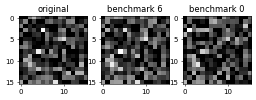

In [120]:
plt.figure(dpi=50)

plt.subplot(1,3,1)
plt.title('original')
plt.imshow(predict(mlp, val_x[68, :].reshape(1,-1), True)[0].reshape(16, 16), cmap='gray')

plt.subplot(1,3,2)
plt.title('benchmark 6')
plt.imshow(benchmarks[0]['pos'][6].reshape(16, 16), cmap='gray')

plt.subplot(1,3,3)
plt.title('benchmark 0')
plt.imshow(benchmarks[0]['pos'][0].reshape(16, 16), cmap='gray')

print(1 / np.linalg.norm(benchmarks[0]['pos'][6] - predict(mlp, val_x[68, :].reshape(1,-1), True)[0]))

Note: improve similarity function and benchmark generation

# Start new from here

<mark>PRINCIPLE: Positive samples and negative samples are subjected to different distribution.</mark>

- get the benchmark feature map (with probabilistic method + a threshold? now the benchmark is mean)
- compare within training samples to calculate 'reliability' (reliability analysis)
- pick top-k reliable layers from $n$ candidates, these k layers are `judge layers`.

---

# Legacy

In [121]:
imgs_obs = list()

In [122]:
for i in range(10):
    plt.figure()

    img1 = pos_dict_fms1[i][0].reshape(16, 16)  # positive_featuremap_avg_layer1
    img2 = neg_dict_fms1[i][0].reshape(16, 16)  # positive_featuremap_avg_layer2
    img3 = pos_dict_fms2[i][0].reshape(10, 10)  # negative_featuremap_avg_layer1
    img4 = neg_dict_fms2[i][0].reshape(10, 10)  # negative_featuremap_avg_layer2
    img5 = pos_dict_fms3[i][0].reshape(8, 8)  # negative_featuremap_avg_layer3
    img6 = neg_dict_fms3[i][0].reshape(8, 8)  # negative_featuremap_avg_layer3
    
    dst1 = np.subtract(img1, img2)
    dst2 = np.subtract(img3, img4)
    dst3 = np.subtract(img5, img6)

    max1 = np.max(img1)
    min1 = np.min(img1)
    max2 = np.max(img3)
    min2 = np.min(img3)
    max3 = np.max(img5)
    min3 = np.min(img5)

    error_percentage_layer1 = np.sum(np.abs(dst1)) / np.sum(np.abs(img1))
    error_percentage_layer2 = np.sum(np.abs(dst2)) / np.sum(np.abs(img3))
    error_percentage_layer3 = np.sum(np.abs(dst3)) / np.sum(np.abs(img5))
    
    imgs = [img1, img2, dst1, img3, img4, dst2, img5, img6, dst3]
    if(i == 5):
        imgs_obs = copy.deepcopy(imgs)
        # print(imgs_obs[0])

    for j in range(9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off')
        plt.title('class:' + str(i))
        plt.imshow(imgs[j], cmap='gray')
        if j < 3 :
            plt.clim(min1, max1)
        elif 3 <= j < 6:
            plt.clim(min2, max2)
        else:
            plt.clim(min3, max3)

    print('class %d correctness: %f' % (i, correct_list[i] / counter_list[i]))
    print('class ' + str(i) + ' e_percentage_l1: ', error_percentage_layer1)
    print('class ' + str(i) + ' e_percentage_l2: ', error_percentage_layer2)
    print('class ' + str(i) + ' e_percentage_l3: ', error_percentage_layer3)

NameError: ignored

<Figure size 432x288 with 0 Axes>

## 看起来错误不是很明显，把正样本分成两部分，丢一些正样本进去对比一下

In [ ]:
fms1 = my_pred[0]   # feature maps first layers
fms2 = my_pred[1]
fms3 = my_pred[2]
pred_lbs = np.array(my_pred[3]).reshape(1, -1)[0].tolist()
print(pred_lbs)

neg_dict_fms1 = {}
neg_dict_fms2 = {}
pos_dict_fms1a = {}
pos_dict_fms2a = {}
pos_dict_fms3a = {}
pos_dict_fms1b = {}
pos_dict_fms2b = {}
pos_dict_fms3b = {}
for i in range(len(pred_lbs)):
    if(pred_lbs[i] != val_y[i]):
        if val_y[i] not in neg_dict_fms1:   # if the first image
            neg_dict_fms1[val_y[i]] = [fms1[i], 1]  # the first is feature map, the second is the time of visiting, by this calculate mean fast
            neg_dict_fms2[val_y[i]] = [fms2[i], 1]
        else:
            neg_dict_fms1[val_y[i]][0] = (neg_dict_fms1[val_y[i]][0] * neg_dict_fms1[val_y[i]][1] + fms1[i]) / (neg_dict_fms1[val_y[i]][1] + 1)
            neg_dict_fms2[val_y[i]][0] = (neg_dict_fms2[val_y[i]][0] * neg_dict_fms2[val_y[i]][1] + fms2[i]) / (neg_dict_fms2[val_y[i]][1] + 1)
            neg_dict_fms1[val_y[i]][1] += 1
            neg_dict_fms2[val_y[i]][1] += 1
    else:
        if(random.uniform(0, 1) < 0.5):
            if val_y[i] not in pos_dict_fms1a:
                pos_dict_fms1a[val_y[i]] = [fms1[i], 1]  # the first is feature map, the second is the time of visiting, by this calculate mean fast
                pos_dict_fms2a[val_y[i]] = [fms2[i], 1]
                pos_dict_fms3a[val_y[i]] = [fms3[i], 1]
            else:
                pos_dict_fms1a[val_y[i]][0] = (pos_dict_fms1a[val_y[i]][0] * pos_dict_fms1a[val_y[i]][1] + fms1[i]) / (pos_dict_fms1a[val_y[i]][1] + 1)
                pos_dict_fms2a[val_y[i]][0] = (pos_dict_fms2a[val_y[i]][0] * pos_dict_fms2a[val_y[i]][1] + fms2[i]) / (pos_dict_fms2a[val_y[i]][1] + 1)
                pos_dict_fms3a[val_y[i]][0] = (pos_dict_fms3a[val_y[i]][0] * pos_dict_fms3a[val_y[i]][1] + fms3[i]) / (pos_dict_fms3a[val_y[i]][1] + 1)
                pos_dict_fms1a[val_y[i]][1] += 1
                pos_dict_fms2a[val_y[i]][1] += 1
                pos_dict_fms3a[val_y[i]][1] += 1
        else:
            if val_y[i] not in pos_dict_fms1b:
                pos_dict_fms1b[val_y[i]] = [fms1[i], 1]  # the first is feature map, the second is the time of visiting, by this calculate mean fast
                pos_dict_fms2b[val_y[i]] = [fms2[i], 1]
                pos_dict_fms3b[val_y[i]] = [fms3[i], 1]
            else:
                pos_dict_fms1b[val_y[i]][0] = (pos_dict_fms1b[val_y[i]][0] * pos_dict_fms1b[val_y[i]][1] + fms1[i]) / (pos_dict_fms1b[val_y[i]][1] + 1)
                pos_dict_fms2b[val_y[i]][0] = (pos_dict_fms2b[val_y[i]][0] * pos_dict_fms2b[val_y[i]][1] + fms2[i]) / (pos_dict_fms2b[val_y[i]][1] + 1)
                pos_dict_fms3b[val_y[i]][0] = (pos_dict_fms3b[val_y[i]][0] * pos_dict_fms3b[val_y[i]][1] + fms3[i]) / (pos_dict_fms3b[val_y[i]][1] + 1)
                pos_dict_fms1b[val_y[i]][1] += 1
                pos_dict_fms2b[val_y[i]][1] += 1
                pos_dict_fms3b[val_y[i]][1] += 1

In [ ]:
for i in range(10):
    plt.figure()

    img1 = pos_dict_fms1a[i][0].reshape(16, 16)  # positive_featuremap_avg_layer1
    img2 = pos_dict_fms1b[i][0].reshape(16, 16)  # positive_featuremap_avg_layer2
    img3 = pos_dict_fms2a[i][0].reshape(10, 10)  # negative_featuremap_avg_layer1
    img4 = pos_dict_fms2b[i][0].reshape(10, 10)  # negative_featuremap_avg_layer2
    img5 = pos_dict_fms3a[i][0].reshape(8, 8)  # negative_featuremap_avg_layer3
    img6 = pos_dict_fms3b[i][0].reshape(8, 8)  # negative_featuremap_avg_layer3
    
    dst1 = np.subtract(img1, img2)
    dst2 = np.subtract(img3, img4)
    dst3 = np.subtract(img5, img6)

    max1 = np.max(img1)
    min1 = np.min(img1)
    max2 = np.max(img3)
    min2 = np.min(img3)
    max3 = np.max(img5)
    min3 = np.min(img5)

    error_percentage_layer1 = np.sum(np.abs(dst1)) / np.sum(np.abs(img1))
    error_percentage_layer2 = np.sum(np.abs(dst2)) / np.sum(np.abs(img3))
    error_percentage_layer3 = np.sum(np.abs(dst3)) / np.sum(np.abs(img5))

    imgs = [img1, img2, dst1, img3, img4, dst2, img5, img6, dst3]

    for j in range(9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off')
        plt.title('class: ' + str(i))
        plt.imshow(imgs[j], cmap='gray')
        if(j < 3):
            plt.clim(min1, max1)
        elif 3 <= j <6:
            plt.clim(min2, max2)
        else:
            plt.clim(min3, max3)

    print('class %d correctness: %f' % (i, correct_list[i] / counter_list[i]))
    print('class ' + str(i) + ' e_percentage_l1: ', error_percentage_layer1)
    print('class ' + str(i) + ' e_percentage_l2: ', error_percentage_layer2)
    print('class ' + str(i) + ' e_percentage_l2: ', error_percentage_layer3)

idea: since we have these trained features, we can consider these features as a criteria for telling wrong samples. For an input model, we don't even have to obtain the last layers, if it's wrong from the beginning.

1. Will you somehow develop a model to distinguish feature maps of incorrect/correct predictions?

**Q: no model needed, instead, a universal criteria will be proposed. e.g. IOU**

2. If so, you might need a systematic evaluation to determine the effectiveness of your method (e.g., which layer we should choose, and how accurate your method is in distinguishing error feature maps).

**Q: To evaluate the method, a inner-group-testing will be performed.**

In [ ]:
a = np.array([9, 9, 8, 8, 2, 2])
b = np.array([9, 8, 8, 2, 2, 3])

idx = np.argwhere(a - b == 0).squeeze()
tmp = np.argwhere(a[idx] == 9).squeeze()

print(tmp)

In [ ]:
# inner-group-testing

val_y = val_y
pred_y = my_pred[-1]

idx = list()
for i in range(len(val_y)):
    if(val_y[i] == 5 and pred_y[i] != 5):
        idx.append(i)

SAMPLE_NUM = 5
rd_selected_index = np.random.choice(idx, SAMPLE_NUM, replace=False)        # randomly select 3 correctly predicted '1' from validation set
sample_imgs = list()
for i in range(SAMPLE_NUM):
    sample_imgs.append(val_x[rd_selected_index[i]])

plt.imshow(sample_imgs[0].reshape(28, 28),cmap='gray')  # check img

In [ ]:
for i in range(SAMPLE_NUM):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_imgs[i].reshape(28, 28),cmap='gray')

In [ ]:
for i, img in enumerate(sample_imgs):
    plt.figure()
    res = predict_label(mlp, img.reshape(1, -1))
    tmpf1 = res[0].reshape(16, 16)      # tmpfs here are all correctly predicted samples
    tmpf2 = res[1].reshape(10, 10)
    tmpf3 = res[2].reshape(8, 8)

    # imgs_obs1 = [img1, img2, dst1, img3, img4, dst2, img5, img6, dst3]        # pos1, neg1, dst1, pos2, ...

    dst1 = np.subtract(imgs_obs[0], tmpf1) # subtract correct sample feature maps with average feature maps
    dst2 = np.subtract(imgs_obs[3], tmpf2)
    dst3 = np.subtract(imgs_obs[6], tmpf3)

    max1 = np.max(imgs_obs[0])
    min1 = np.min(imgs_obs[0])
    max2 = np.max(imgs_obs[3])
    min2 = np.min(imgs_obs[3])
    max3 = np.max(imgs_obs[6])
    min3 = np.min(imgs_obs[6])

    error_percentage_layer1 = np.sum(np.abs(dst1)) / np.sum(np.abs(imgs_obs[0]))
    error_percentage_layer2 = np.sum(np.abs(dst2)) / np.sum(np.abs(imgs_obs[3]))
    error_percentage_layer3 = np.sum(np.abs(dst3)) / np.sum(np.abs(imgs_obs[6]))

    imgs = [imgs_obs[0], tmpf1, dst1, imgs_obs[3], tmpf2, dst2, imgs_obs[6], tmpf3, dst3]
    # if i == 1:
    #     print(imgs_obs[0])

    for j in range(9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off')
        plt.title('class 5 sample ' + str(i))
        plt.imshow(imgs[j], cmap='gray')
        if(j < 3):
            plt.clim(min1, max1)
        elif 3 <= j <6:
            plt.clim(min2, max2)
        else:
            plt.clim(min3, max3)

    print('class %d correctness: %f' % (5, correct_list[5] / counter_list[5]))
    print('sample ' + str(i) + ' e_percentage_l1: ', error_percentage_layer1)
    print('sample ' + str(i) + ' e_percentage_l2: ', error_percentage_layer2)
    print('sample ' + str(i) + ' e_percentage_l2: ', error_percentage_layer3)


```python
num 0 correctness: 0.965318
num 1 correctness: 0.971366
num 2 correctness: 0.955594
num 3 correctness: 0.919502
num 4 correctness: 0.958089
num 5 correctness: 0.948405
num 6 correctness: 0.967078
num 7 correctness: 0.956654
num 8 correctness: 0.957722
num 9 correctness: 0.940150
```
Number '3' is harder to recognize, let's try the experiment on '3'